In [2]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
import MEVeS as S
importlib.reload(S)
import AtomicConstants as AC
importlib.reload(AC)
import Optimiser as Opt
importlib.reload(Opt)
import timeit

# Normal TORCA

In [2]:
import AtomicConstants as AC
importlib.reload(AC)

# Make atom class

config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

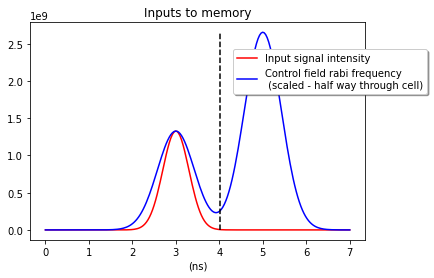

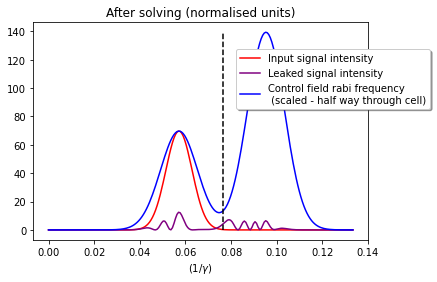

Storage Efficiency = 0.5565057869032903
Total Efficiency = 0.0865900186581916


In [10]:
import MEVeS as S
importlib.reload(S)

protocol = 'TORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 7e-9
tbounds = np.array([0, tend])

m = 200
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 2e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[int(4*m/7)]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[int(4*m/7)], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, int((t0+tau)*m/(tend)))

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, int((t0+tau)*m/(tend)), 0)

print("Total Efficiency = " + str(eff))

### With hyperfine splitting

In [8]:
import AtomicConstants as AC
importlib.reload(AC)

# Make atom class

config = {"Hyperfine splitting": True, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

#atom.angular_frequencies[1] = atom.angular_frequencies[0] # removes doppler dephasing

In [16]:
 len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq)

(1, 5, 4, 9)

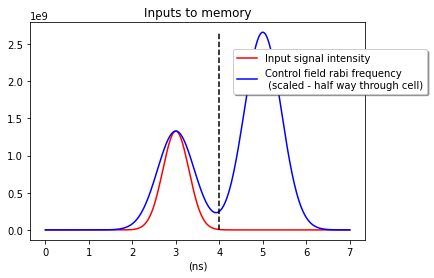

here
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276

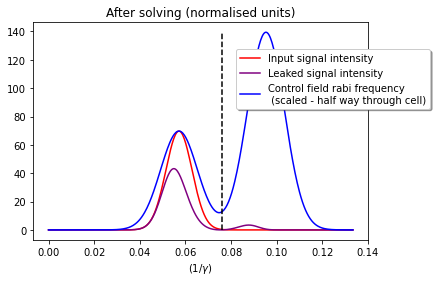

Storage Efficiency = 0.1041870622715053
Total Efficiency = 0.03589738909874866


In [17]:
import MEVeS as S
importlib.reload(S)

protocol = 'TORCAP'


OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 7e-9
tbounds = np.array([0, tend])

m = 400
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 2e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[int(4*m/7)]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

print('here')

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[int(4*m/7)], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, int((t0+tau)*m/(tend)))

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, int((t0+tau)*m/(tend)), 0)

print("Total Efficiency = " + str(eff))

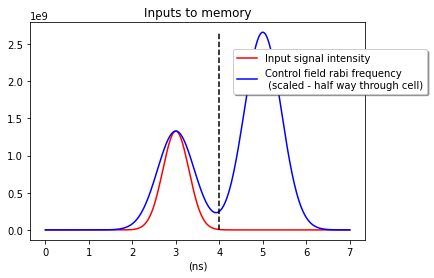

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


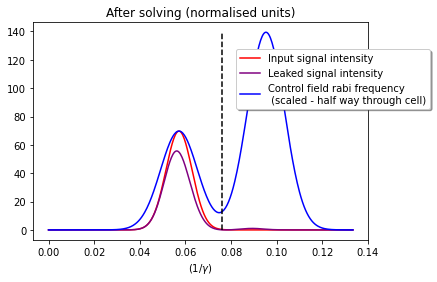

Storage Efficiency = 0.11737112211988297
Total Efficiency = 0.012633604707575704


In [15]:
import MEVeS as S
importlib.reload(S)

protocol = 'TORCA'


OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 7e-9
tbounds = np.array([0, tend])

m = 400
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 2e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[int(4*m/7)]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[int(4*m/7)], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, int((t0+tau)*m/(tend)))

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, int((t0+tau)*m/(tend)), 0)

print("Total Efficiency = " + str(eff))

# TORCAP

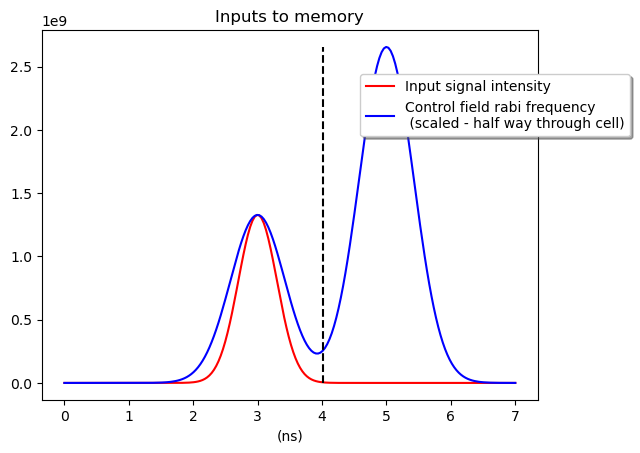

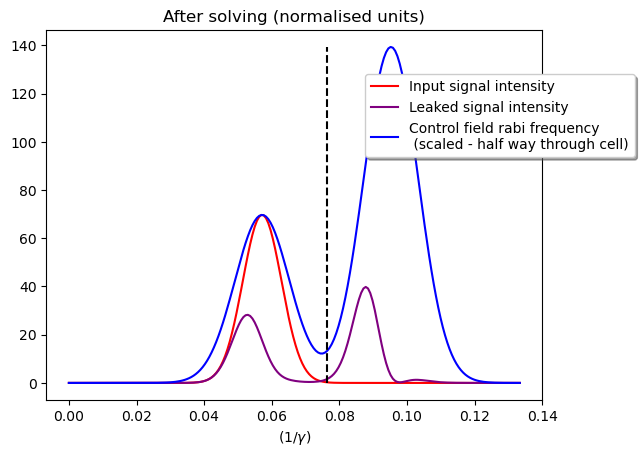

Storage Efficiency = 0.6589652124964547
Total Efficiency = 0.3849209280755003


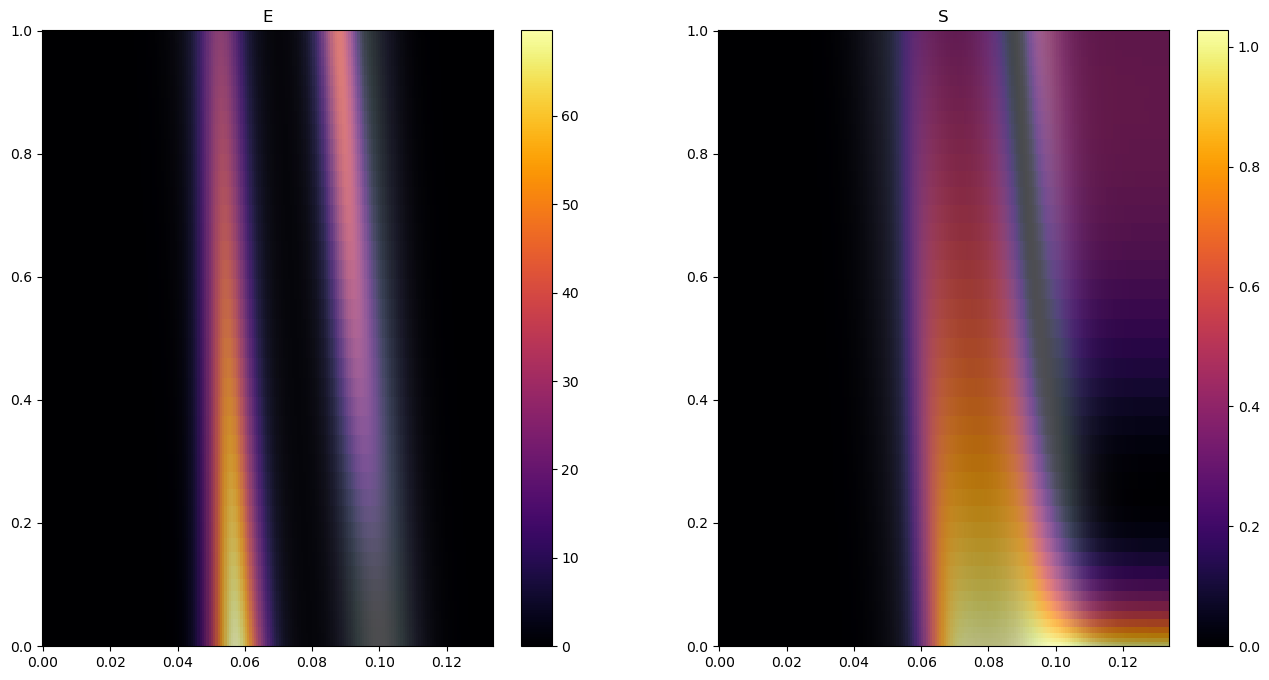

In [5]:
# First run normal TORCA

protocol = 'TORCA'

OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 7e-9
tbounds = np.array([0, tend])

m = 200
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 2e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[int(4*m/7)]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[int(4*m/7)], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, int((t0+tau)*m/(tend)))

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, int((t0+tau)*m/(tend)), 0)

print("Total Efficiency = " + str(eff))

# 2d plots of coherences

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax[0].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.E[:, :, 0]),2).T, cmap=colour)

ax[0].set_title('E')

fig.colorbar(im, ax=ax[0])

ax[0].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

im = ax[1].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.S[:, :, 0, 0, 0, 0, 0]),2).T, cmap=colour)

ax[1].set_title('S')

fig.colorbar(im, ax=ax[1])

ax[1].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)


plt.show()

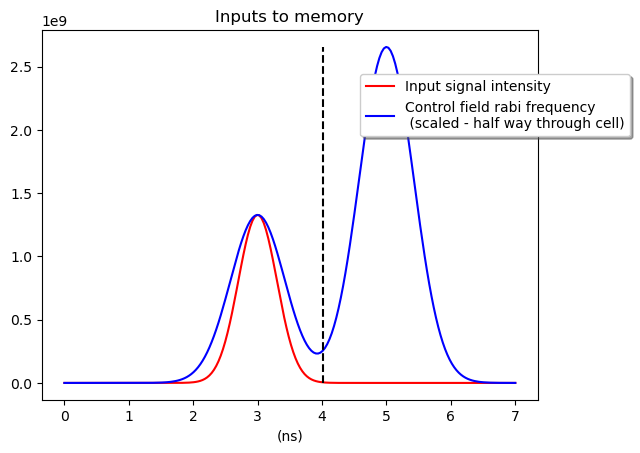

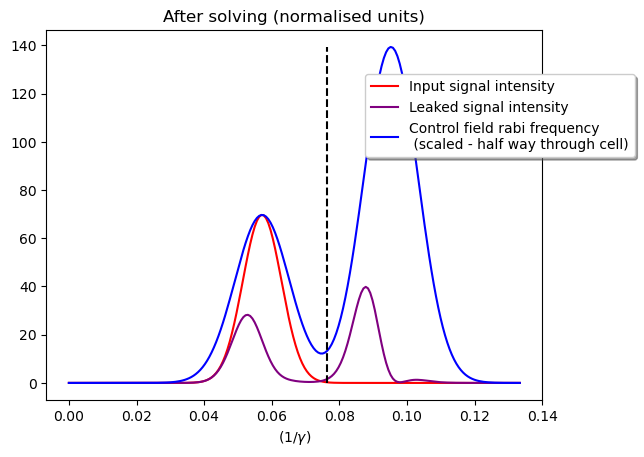

Storage Efficiency = 0.6585150847755619
Total Efficiency = 0.3857271446870558


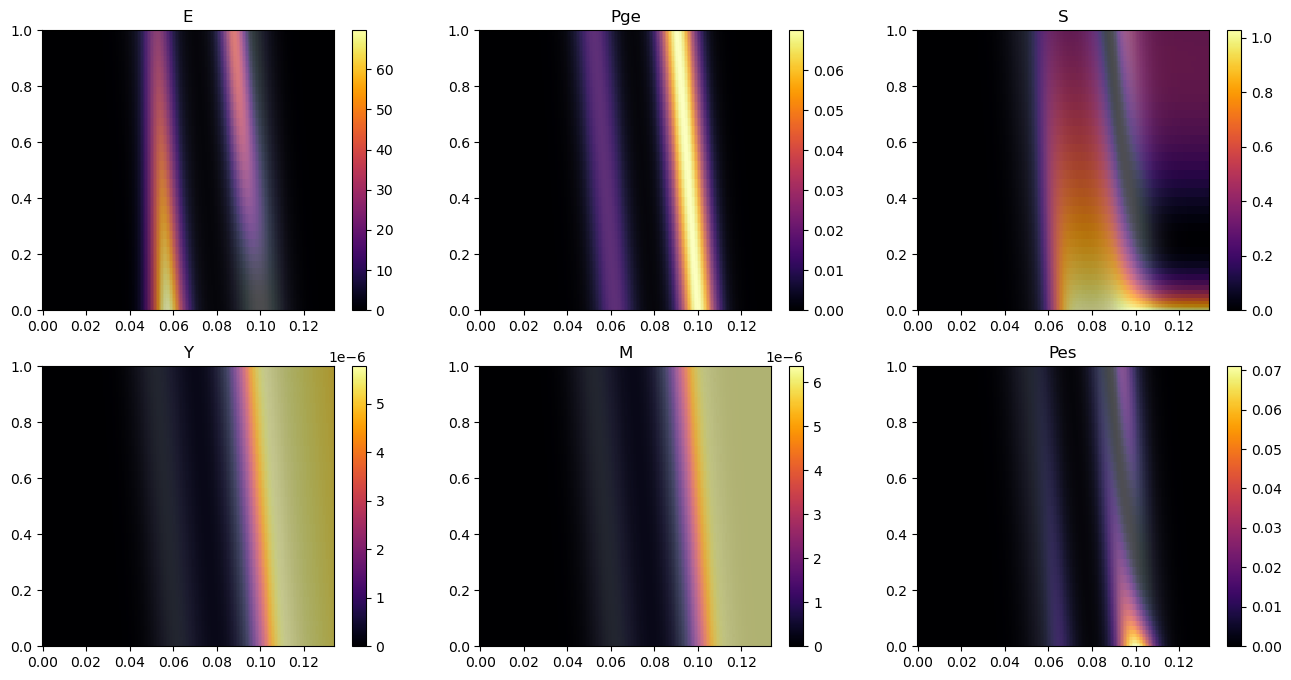

In [7]:
import MEVeS as S
importlib.reload(S)

protocol = 'TORCAP'

OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 7e-9
tbounds = np.array([0, tend])

m = 200
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 2e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[int(4*m/7)]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[int(4*m/7)], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, int((t0+tau)*m/(tend)))

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, int((t0+tau)*m/(tend)), 0)

print("Total Efficiency = " + str(eff))

# 2d plots of coherences

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax[0, 0].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.E[:, :, 0]),2).T, cmap=colour)

ax[0, 0].set_title('E')

fig.colorbar(im, ax=ax[0, 0])

ax[0, 0].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

im = ax[0, 1].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.Pge[:, :, 0, 0, 0, 0, 0]),2).T, cmap=colour)

ax[0, 1].set_title('Pge')

fig.colorbar(im, ax=ax[0, 1])

ax[0, 1].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

im = ax[0, 2].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.S[:, :, 0, 0, 0, 0, 0]),2).T, cmap=colour)

ax[0, 2].set_title('S')

fig.colorbar(im, ax=ax[0, 2])

ax[0, 2].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

im = ax[1, 0].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.Yee[:, :, 0, 0, 0, 0, 0]),2).T, cmap=colour)

ax[1, 0].set_title('Y')

fig.colorbar(im, ax=ax[1, 0])

ax[1, 0].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

im = ax[1, 1].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.Mgg[:, :, 0, 0, 0, 0, 0]),2).T, cmap=colour)

ax[1, 1].set_title('M')

fig.colorbar(im, ax=ax[1, 1])

ax[1, 1].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

im = ax[1, 2].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.Pes[:, :, 0, 0, 0, 0, 0]),2).T, cmap=colour)

ax[1, 2].set_title('Pes')

fig.colorbar(im, ax=ax[1, 2])

ax[1, 2].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

plt.show()

### Full manifold

In [2]:
config = {"Hyperfine splitting": True, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

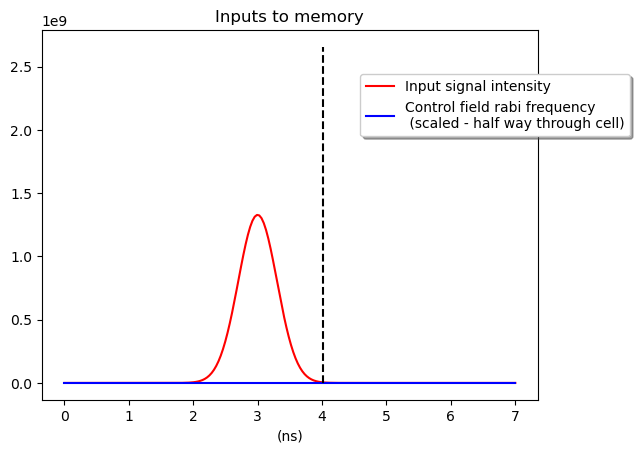

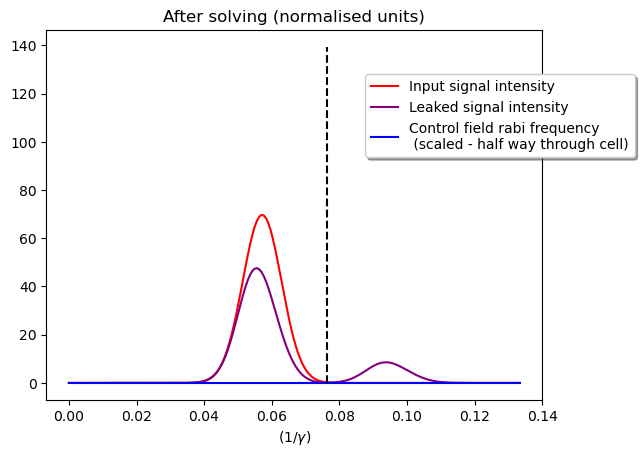

Storage Efficiency = 0.3268129961614893
Total Efficiency = 0.13110203685107122


In [4]:
import MEVeS as S
importlib.reload(S)

protocol = 'TORCAP'

OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 7e-9
tbounds = np.array([0, tend])

m = 200
t = np.linspace(0, tend, m)

photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 1e10
Omega_retrieve = 1e10
tr = 2e-9
control_pol = np.sqrt(1/2)*np.array([1, -1])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

plt.plot(t*1e9, pow(Einits[:, 0], 2) + pow(Einits[:, 1], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, ((pow(Einits[:, 0], 2) + pow(Einits[:, 1], 2))/Omega_store) * (Control_tp[:, 0] + Control_tp[:, 1]), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[int(4*m/7)]*1e9, 0, 2*max(pow(Einits[:, 0], 2) + pow(Einits[:, 1], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2) + pow(np.abs(sol.E[:, 0, 1]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2) + pow(np.abs(sol.E[:, -1, 1]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(pow(np.abs(sol.E[:, 0, 0]),2) + pow(np.abs(sol.E[:, 0, 1]),2)), 2)/Omega_store)*(Control_tp[:, 0] + Control_tp[:, 1]), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[int(4*m/7)], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]),2) + pow(np.abs(sol.E[:, 0, 1]),2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, int((t0+tau)*m/(tend)))

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, int((t0+tau)*m/(tend)), 0) + sol.retrieval_efficiency(sol.E, int((t0+tau)*m/(tend)), 1)

print("Total Efficiency = " + str(eff))

## Experiment parameters

## Efficiency vs storage time